# 🚶 Moving Average 

This will make you think that till now ***whatever*** that we have learnt was a lie. That might be exaggeration but the term ***Moving Average (MA)*** here *isn't* the MA that we have learn't till now.

Because here we use the ***errors to build the formulae***. <br>
Let's get right in.

## The Linear Function... again?
Oh my! Is the time-series forecasting really made of some kind of "linear functions" but modified in *some* way? Does it look like that? I mean, really again the *formulae* for the Moving Average is ***also*** a linear combinations of the error terms! Just the values are changed, here they are the "errors".

# $$ y_t = c + \varepsilon_t + \theta_1\varepsilon_{t-1} + \theta_2\varepsilon_{t-2} + \cdots + \theta_q\varepsilon_{t-q}$$

Here, <br>
$\varepsilon_t:$ is the error of current time. The latest time. <br>
$\varepsilon:$ is the error. The simple residual. The simple mistake. The simple $\hat y - y$. Nothing special. But wait, to get the errors, you will *first need to make predictions*, right? <br>
$\theta:$ is the slope, as we had seen in the previoud AR(p) model where they were the $\varphi$. Which are learnt and adjusted. <br>
$q:$ is the "q". I mean really, not $p$. Like the "p" here, we can **set** the "q". So, basically it defines: *"on how many errors do you want to base your forecast on?"*

### The AR(p) for your reference:
# $$ \hat y_t = b + \varphi_1y_{t - 1} + \varphi_2y_{t - 2} + \cdots + \varphi_py_{t - p} + \varepsilon_t$$

Just the change in `b` → `c` and likewise.

##### 

## 🤔 But where is the moving average?

**`1.` On the author's note, he explains:** <br>
<img src="../images/error-ma.png" height=400 width=500>

The *"expected value"* of the time-series data, is $E(y_t)$ and that equals to the equation that we have just written. 

**Recall** that we defined the error term $\varepsilon \sim \aleph (0, \sigma^2)$. Which means that comes from the normal distribution where the *mean is 0*. *(Don't get excited, it is not why it is called average...)* since the error's expected value is `0` then we can say that **$\varepsilon$** will be zero?

This is the situation where the **bias term `c`** stays alone in the formulae and then the expected value of the ***y*** or $E(y_t)$ is equals to ***c***! Thus, the errors (the $\varepsilon$) make the *fluctuations* in the $E(y_t)$ ***around*** the bias `c`. 

> Hence, I guess we can call it the Moving Average! What a story!

###### 

**`2.` The internet says this:**

<img src="../images/why-ma-1.png" height=400 width=500>

___

<img src="../images/why-ma-2.png" height=400 width=500>

Have a look on this conversation: [here](https://stats.stackexchange.com/questions/58242/why-are-maq-time-series-models-called-moving-averages). <br>
But still, whatever we have till now — we just have to remember that:
- The MA(q) model is the linear combination of errors.
- It requires the term `q` which defines on how many past errors do we need to consider.
- And, it is called the Moving Average, "why" is the mysterious term.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("../data/airline_passengers.csv", index_col=0, parse_dates=True)
df = df.Passengers
df.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: Passengers, dtype: int64

In [3]:
train = df.iloc[:-12]
test = df.iloc[-12:]

In [4]:
train = train.values.reshape(-1)

In [5]:
# `p` because the things are same initially.
p = 5
X = []
y = []
for i in range(0, len(train) - p):
    X.append(train[i:p+i].tolist())
    y.append(train[p+i])

First we will build the X as we did in the AR(p) model. Just the same. We will build the model with that and then make the initial predictions. From which we will get the errors and since we have the errors, we will be able to do more.

In [6]:
X = np.array(X)
y = np.array(y)

In [7]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [8]:
preds = model.predict(X)

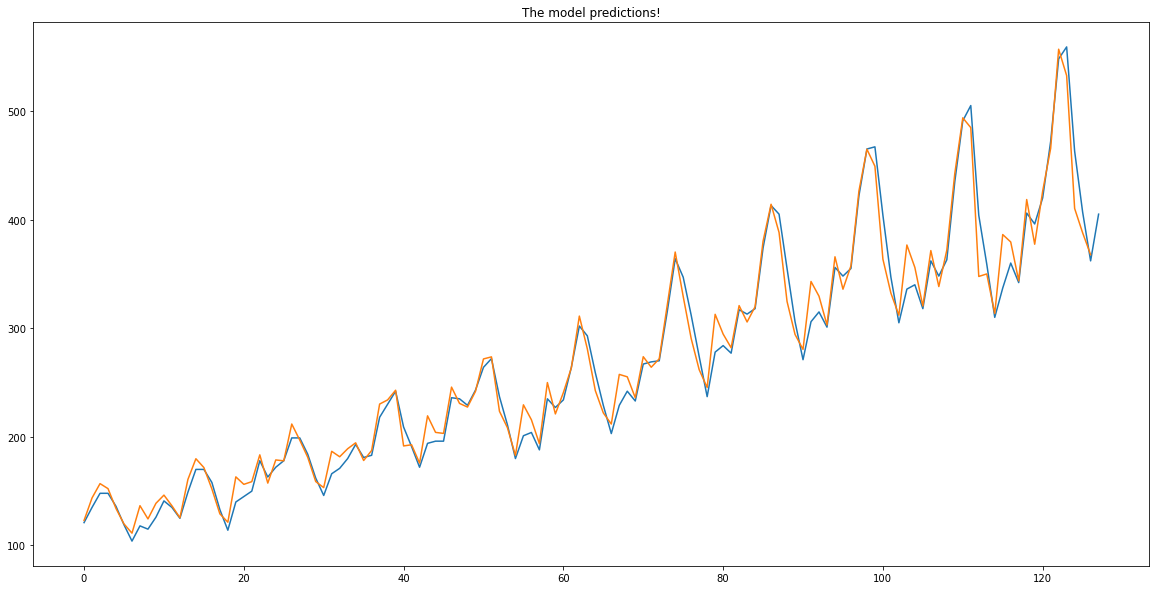

In [9]:
plt.plot(train[p-1:])
plt.plot(preds)
plt.title("The model predictions!");

Note that we have deleted the previous `q` true points (or previous 5 points) to make things align. <br>
And... man! Did you see?

The model is able to forecast! Our little kid LR!

Now, these are the errors:

In [10]:
errors = preds - y
errors[:5]

array([-11.99367966,  -4.26826762,   8.91715801,  16.28479898,
        14.97863193])

There are our errors. Since, we have them let's predict the future with them. **But not directly** we will need to train ***another model***.

In [11]:
# This is the `q`... keeping it the same as `p` before for simplysity
q = 5
eX = []
ey = []
for i in range(0, len(errors) + 1 - q):
    eX.append(errors[i:q+i].tolist())
    ey.append(train[q+q+i-1]) # q is twice because we are ignoring the first `q` elements

Here, till now, we have prepared the `eX` or errors and `ey` for the real values. That means, we will predict the real values `y` from the errors!

Now, frankly... I am not sure how to move forward. The reasons are:
- To make prediction with the error, you need new error
    - We can generate the new error from the sample... 
    - Or, if we have the test data, we get the error and append in the data to make new preds
- Unlike the AR(p) model, we were using the same prediction as the input for the new data
    - But here to do that we will have to use 2 models together
        - First to predict the y
        - The get the error and use that error to get another y from second model!
        
Now... I am moving forward ***by generating the error!*** 

In [12]:
eX = np.array(eX)
ey = np.array(ey)

In [13]:
error_model = LinearRegression()
error_model.fit(eX, ey)

LinearRegression()

In [14]:
seed = np.random.RandomState(1)

In [15]:
preds = []
Xt = eX[-1].reshape(1, -1)
for i in range(12):
    pred = error_model.predict(Xt)[0]
    preds.append(pred)
    
    synthetic_error = seed.choice(errors)
    Xt = np.c_[Xt, synthetic_error][0, -q:].reshape(1, -1)

In [16]:
preds = pd.Series(preds, index=test.index)

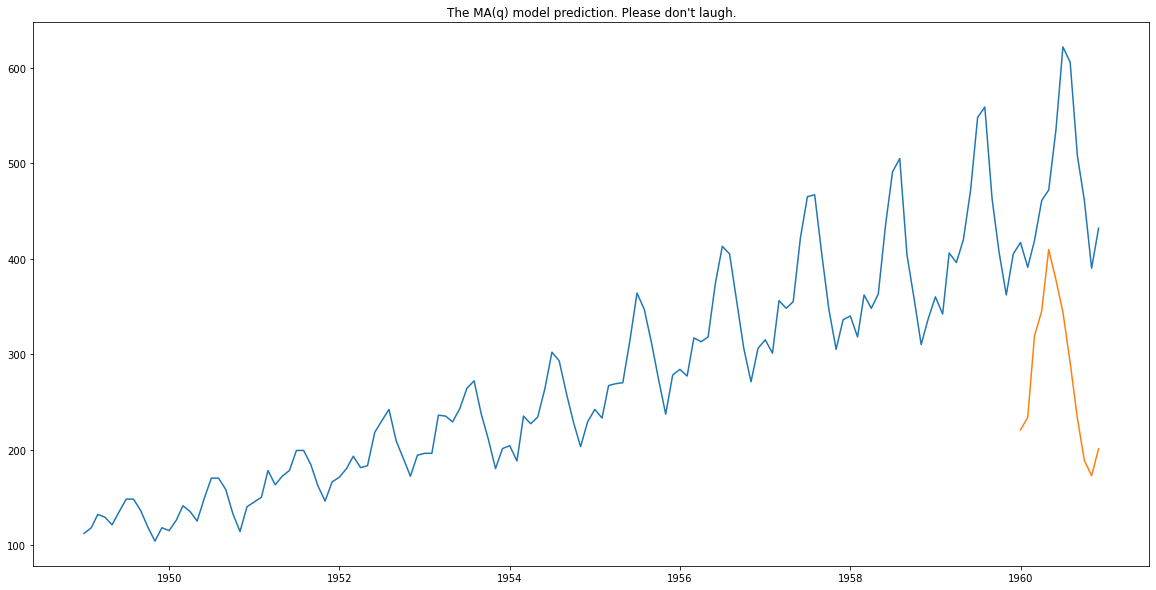

In [17]:
plt.plot(df)
plt.plot(preds)
plt.title("The MA(q) model prediction. Please don't laugh.");

And really! That's the prediction!

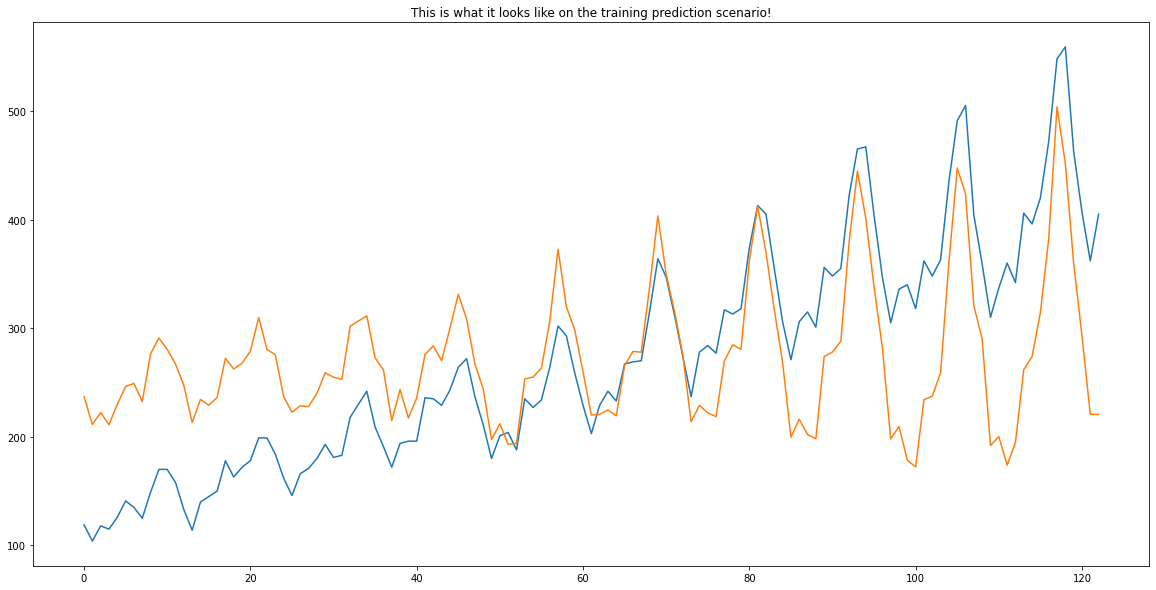

In [18]:
plt.plot(train[9:])
plt.plot(error_model.predict(eX))
plt.title("This is what it looks like on the training prediction scenario!");

So, I think we are doing something okay... *if not perfect*.

More Predictions?

In [19]:
preds = []
Xt = eX[-1].reshape(1, -1)
for i in range(72):
    pred = error_model.predict(Xt)[0]
    preds.append(pred)
    
    synthetic_error = seed.choice(errors)
    Xt = np.c_[Xt, synthetic_error][0, -q:].reshape(1, -1)

In [20]:
new_idx = pd.date_range(test.index[0], periods=72, freq="M")

In [21]:
preds = pd.Series(preds, index=new_idx)

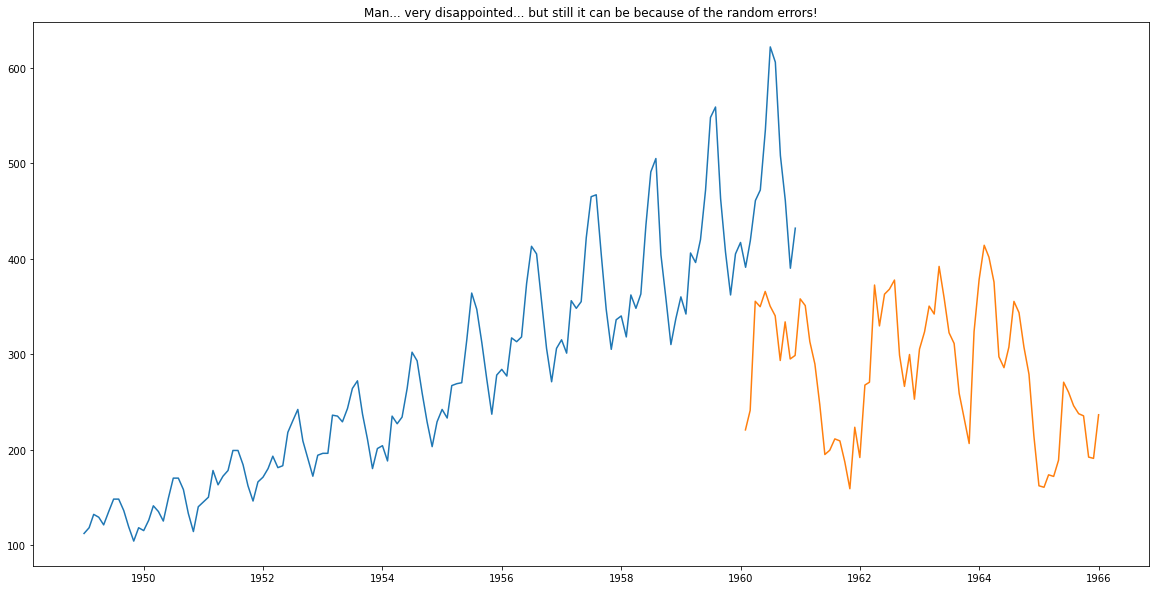

In [22]:
plt.plot(df)
plt.plot(preds)
plt.title("Man... very disappointed... but still it can be because of the random errors!");

# 

# Anyways,
That was a fun. Let's see how the ***full ARIMA model works!***